# Homework: Compare Two Logistic Regression Models (Weather & Climate)

**Compare the performance of two logistic regression models**  
- **Model A (Full):** `CAPE`, `PWAT`, `Shear`  
- **Model B (Reduced):** `CAPE`, only

Does the three parameter model work better than the one parameter model?

**Tasks**
1. Split data into train/test.
2. Fit both models.
3. Compute **accuracy**, **precision**, **recall** at threshold 0.5.
4. Plot **ROC** and **Precision–Recall** curves for both models on the same figures.
5. Answer the interpretation questions.


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

FEATURES_FULL = ['cape','pwat','shear']
FEATURES_REDUCED = ['cape']
TARGET = 'event'

# Synthetic fallback
USE_SYNTHETIC = True

if USE_SYNTHETIC:
    rng = np.random.default_rng(42)
    n = 1200
    cape  = rng.gamma(5.0, 250.0, size=n)
    pwat  = rng.normal(30, 8, size=n).clip(5, 70)
    shear = rng.normal(15, 6, size=n).clip(0, 40)
    z = -6.0 + 0.0025*cape + 0.06*pwat + 0.05*shear + 0.00002*cape*shear
    p = 1/(1+np.exp(-z))
    y = rng.binomial(1, p)
    df = pd.DataFrame({'cape':cape, 'pwat':pwat, 'shear':shear, 'event':y})
else:
    df = pd.read_csv('../data/your_data.csv').dropna()
    assert TARGET in df.columns
    assert all(c in df.columns for c in FEATURES_FULL)
    df = df[FEATURES_FULL + [TARGET]]
df.head()

,cape,pwat,shear,event
0,1339.091679,24.846334,4.350342,1
1,1620.699558,34.709626,23.376549,1
2,1237.079261,26.431445,20.809474,1
3,1157.616507,37.841527,29.506833,1
4,1708.955858,32.249385,6.662860,1


## 1) Train/Test Split

In [2]:
# TODO: Split into train/test for both feature sets using SAME random_state and stratify by y
X_full = df[FEATURES_FULL].values
X_reduced = df[FEATURES_REDUCED].values
y = df[TARGET].values.astype(int)

# YOUR CODE HERE
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_full, y, test_size=0.25, random_state=0, stratify=y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.25, random_state=0, stratify=y)

len(Xf_train), len(Xf_test)

(900, 300)

## 2) Fit Both Logistic Regression Models

In [3]:
# TODO: Fit two LogisticRegression models (full and reduced). Use max_iter >= 200.
# YOUR CODE HERE
clf_full = LogisticRegression(max_iter=200).fit(Xf_train, yf_train)
clf_reduced = LogisticRegression(max_iter=200).fit(Xr_train, yr_train)

yprob_full = clf_full.predict_proba(Xf_test)[:,1]
yprob_reduced = clf_reduced.predict_proba(Xr_test)[:,1]

clf_full.coef_, clf_reduced.coef_

(array([[0.00294362, 0.0514564 , 0.0928135 ]]), array([[0.00269818]]))

## 3) Metrics at Threshold 0.5

In [4]:
thr = 0.5
ypred_full = (yprob_full >= thr).astype(int)
ypred_reduced = (yprob_reduced >= thr).astype(int)

# TODO: Compute Accuracy, Precision, Recall for both models at threshold 0.5

In [ ]:
# Compute Accuracy for full model at threshold 0.5
accuracy_score(yf_test, ypred_full)

0.7233333333333334

In [11]:
# Compute Accuracy for reduced model at threshold 0.5
accuracy_score(yr_test, ypred_reduced)

0.7166666666666667

In [12]:
# Compute Precision for full model at threshold 0.5
precision_score(yf_test, ypred_full)

0.7333333333333333

In [13]:
# Compute Precision for reduced model at threshold 0.5
precision_score(yr_test, ypred_reduced)

0.7364341085271318

In [14]:
# Compute Recall for full model at threshold 0.5
recall_score(yf_test, ypred_full)

0.678082191780822

In [15]:
# Compute Recall for reduced model at threshold 0.5
recall_score(yr_test, ypred_reduced)

0.6506849315068494

## 4) Plot ROC and Precision–Recall Curves

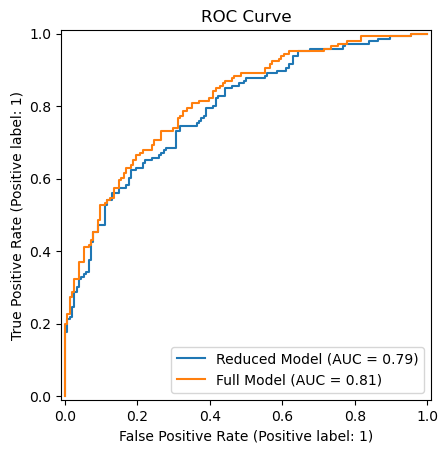

In [ ]:
# TODO: Plot ROC and PR curves for both models on shared axes

# ROC - plot both ROC curves on shared axes

fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(yr_test, yprob_reduced, ax=ax, name="Reduced Model")
RocCurveDisplay.from_predictions(yf_test, yprob_full, ax=ax, name="Full Model")

ax.set_title("ROC Curve")

plt.show()

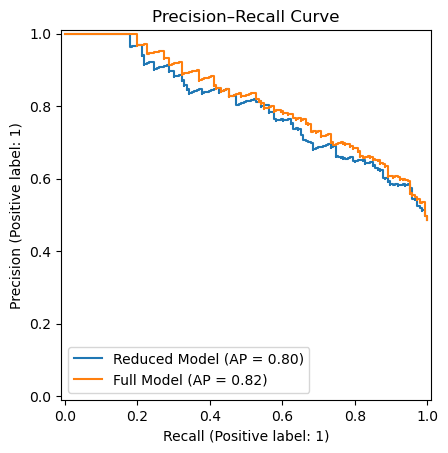

In [19]:
# TODO: Plot ROC and PR curves for both models on shared axes

# PR - plot both PR curves on shared axes

fig, ax = plt.subplots()

PrecisionRecallDisplay.from_predictions(yr_test, yprob_reduced, ax=ax, name="Reduced Model")
PrecisionRecallDisplay.from_predictions(yf_test, yprob_full, ax=ax, name="Full Model")

ax.set_title("Precision–Recall Curve")

plt.show()


## 5) Interpretation

1. Which model has higher **ROC-AUC** and **PR-AUC**? What does this imply about `PWAT`?  
2. Compare **accuracy**, **precision**, and **recall** for both models.  
   - Which model would you choose to **maximize event detection** (recall)?  
   - Which model would you choose to **minimize false alarms** (precision)?  

1) Which model has higher ROC-AUC? 
    The full model has a higher ROC-AUC. The full model has an AUC of 0.81, while the reduced model has an AUC of 0.79. 
   Which model has a higher PR-AUC?
    The full model has a higher PR-AUC. The full model has an AP of 0.82, while the reduced model has an AP of 0.80. 
   This implies that PWAT (Precipitable water / water contained in the atmosphere) is useful in modeling CAPE and shear. 

2) Compare accuracy, precision, and recall for both models.
   
   Which model would you choose to maximize event detection (recall)?
    Full. The full model has a higher recall score (0.678) than the reduced model (0.651).
   Which model would you choose to minimize false alarms (precision)?
    Reduced. The reduced model has a higher precision score (0.736) than the full model (0.733).